In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

In [45]:
df = pd.read_csv(r"C:\Users\Lenovo\OneDrive\Desktop\Lead case study\ded03f4f-6db1-468b-b4fd-16e5a6763385-Lead-Scoring-Case-Study (1)\Lead Scoring Assignment\Leads.csv")

In [4]:
# Display the first few rows
print("Initial Data:")
print(df.head())

Initial Data:
                            Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit  ...  \
0                

In [5]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [6]:
df.isnull().sum()

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   1438
How did you hear about X Education               2207
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article           

In [7]:
# A significant number of columns have a high percentage of missing values.
# 'Country' and 'City' have many missing values and can be imputed or dropped.
# Many categorical columns have 'Select' as a value, which is effectively a missing value.
# Let's replace 'Select' with 'Unknown' or np.nan.
for col in ['Specialization', 'How did you hear about X Education', 'Lead Profile', 'City']:
    df[col] = df[col].replace('Select', np.nan)

In [8]:
# Re-check missing values after handling 'Select'
print("\nMissing Values after replacing 'Select':")
print(df.isnull().sum())


Missing Values after replacing 'Select':
Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   3380
How did you hear about X Education               7250
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                

In [9]:
# Drop columns with a large number of missing values (e.g., > 30% of data)
total_rows = df.shape[0]
for col in df.columns:
    if df[col].isnull().sum() / total_rows > 0.3:
        df = df.drop(col, axis=1)

In [10]:
# Impute remaining missing values. For categorical columns, we'll use the mode.
# For numerical columns, we can use the mean or median.
for col in ['Last Activity', 'Tags', 'Lead Quality', 'City', 'Last Notable Activity', 'What is your current occupation', 'Country', 'Lead Source', 'Lead Origin', 'Specialization']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

In [11]:
for col in ['TotalVisits', 'Page Views Per Visit', 'Total Time Spent on Website']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

In [12]:
# Check for zero values that might represent missing data
print("\nChecking for zero values in key numerical columns:")
print(df[['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']].isin([0]).sum())


Checking for zero values in key numerical columns:
TotalVisits                    2189
Total Time Spent on Website    2193
Page Views Per Visit           2189
dtype: int64


In [13]:
# Drop columns with too many missing values (> 40%)
missing_ratio = df.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.4].index
df.drop(columns=cols_to_drop, inplace=True)

In [14]:
#  Missing value handling (mode/median imputation)
# Mode imputation for object columns
mode_impute = {col: df[col].mode()[0] for col in df.select_dtypes(include='object').columns}
# Median imputation for numeric columns
median_impute = {col: df[col].median() for col in df.select_dtypes(include=['float64','int64']).columns}

df.fillna({**mode_impute, **median_impute}, inplace=True)

In [15]:
#  Outlier handling (optional - cap extreme outliers at 1st and 99th percentile)
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = np.clip(df[col], lower, upper)

In [16]:
#  Separate target and features
X = df.drop('Converted', axis=1)   # features
y = df['Converted']                # target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
#  Identify numerical and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [18]:
# Preprocessing pipeline with additional steps
numeric_transformer = Pipeline(steps=[
('scaler', StandardScaler()),
('power', PowerTransformer(method='yeo-johnson')) # Normalize skewed features
])


categorical_transformer = Pipeline(steps=[
('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
transformers=[
('num', numeric_transformer, numeric_features),
('cat', categorical_transformer, categorical_features)
])

In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
# Preprocess features
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [21]:
# Convert binary variables to 0/1
binary_vars = ['Do Not Email', 'Do Not Call', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Converted']
for var in binary_vars:
    df[var] = df[var].map({'Yes': 1, 'No': 0, 1: 1, 0: 0})

In [22]:
# Get dummy variables for categorical features
categorical_vars = df.select_dtypes(include='object').columns.tolist()
df_dummies = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

In [23]:
# Separate features (X) and target (y)
X = df_dummies.drop('Converted', axis=1)
y = df_dummies['Converted']

In [24]:
# Scale numerical features
scaler = StandardScaler()
numerical_vars = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
X_train[numerical_vars] = scaler.fit_transform(X_train[numerical_vars])
X_test[numerical_vars] = scaler.transform(X_test[numerical_vars])


In [46]:
# ROC-AUC Score
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.4879


In [26]:
# Feature selection: remove near-zero variance features
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
X_train_preprocessed = selector.fit_transform(X_train_preprocessed)
X_test_preprocessed = selector.transform(X_test_preprocessed)

In [27]:
# Handle class imbalance using SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_preprocessed, y_train)

In [28]:
print("✅ Advanced data preprocessing completed (outlier handling, normalization, feature selection, SMOTE)")
print(f"Final training data shape after SMOTE: {X_train_balanced.shape}")

✅ Advanced data preprocessing completed (outlier handling, normalization, feature selection, SMOTE)
Final training data shape after SMOTE: (9086, 37)


Insights


In [29]:
# Convert binary variables to 0/1
binary_vars = ['Do Not Email', 'Do Not Call', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Converted']
for var in binary_vars:
    df[var] = df[var].map({'Yes': 1, 'No': 0, 1: 1, 0: 0})

In [30]:
# Get dummy variables for categorical features
categorical_vars = df.select_dtypes(include='object').columns.tolist()
df_dummies = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

In [31]:
# Separate features (X) and target (y)
X = df_dummies.drop('Converted', axis=1)
y = df_dummies['Converted']

In [32]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
# Scale numerical features
scaler = StandardScaler()
numerical_vars = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
X_train[numerical_vars] = scaler.fit_transform(X_train[numerical_vars])
X_test[numerical_vars] = scaler.transform(X_test[numerical_vars])

In [34]:
# Build the logistic regression model
logreg = LogisticRegression(solver='liblinear', random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [35]:
# Make predictions on the test set
y_pred = logreg.predict(X_test)

In [36]:
# Accuracy
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")


Accuracy: 0.6115


In [37]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[1695    0]
 [1077    0]]


In [38]:
# Precision and Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.0000
Recall: 0.0000


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
# ROC-AUC Score
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.4879


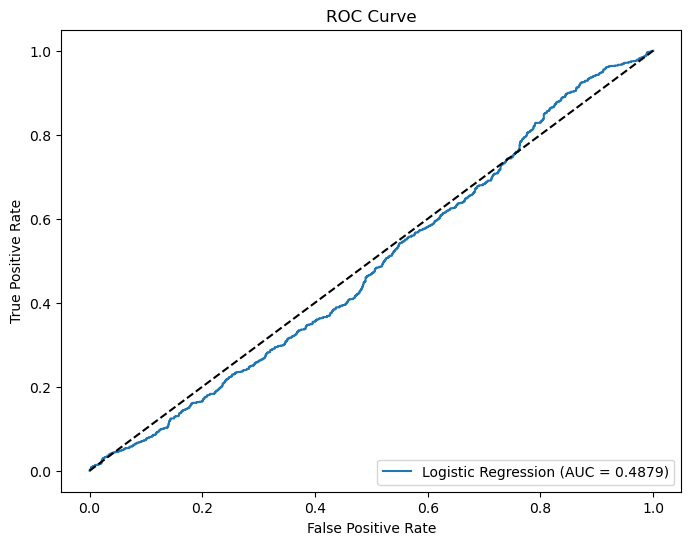

In [47]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [50]:
# --- Lead Scoring ---
# The logistic regression model outputs probabilities, which can be scaled to a 0-100 score.
lead_scores = y_pred_proba * 100
print("\nSample Lead Scores:")
print(lead_scores[:10].round(2))


Sample Lead Scores:
[38.5  38.98 38.4  38.96 37.85 37.87 37.75 37.89 39.   37.99]


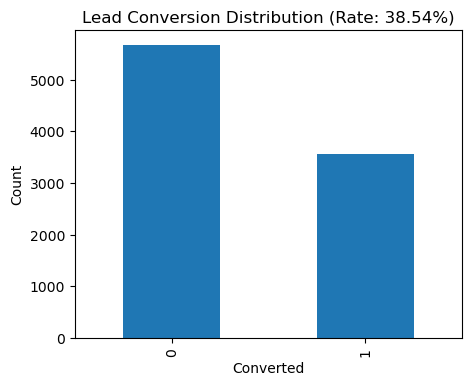

 Overall conversion rate is 38.54%, a benchmark for lead nurturing success.


In [51]:
#  Overall Conversion Rate
import matplotlib.pyplot as plt
import seaborn as sns
conversion_rate = y.mean() * 100
plt.figure(figsize=(5, 4))
y.value_counts().plot(kind='bar')
plt.title(f'Lead Conversion Distribution (Rate: {conversion_rate:.2f}%)')
plt.xlabel('Converted')
plt.ylabel('Count')
plt.show()
print(f" Overall conversion rate is {conversion_rate:.2f}%, a benchmark for lead nurturing success.")

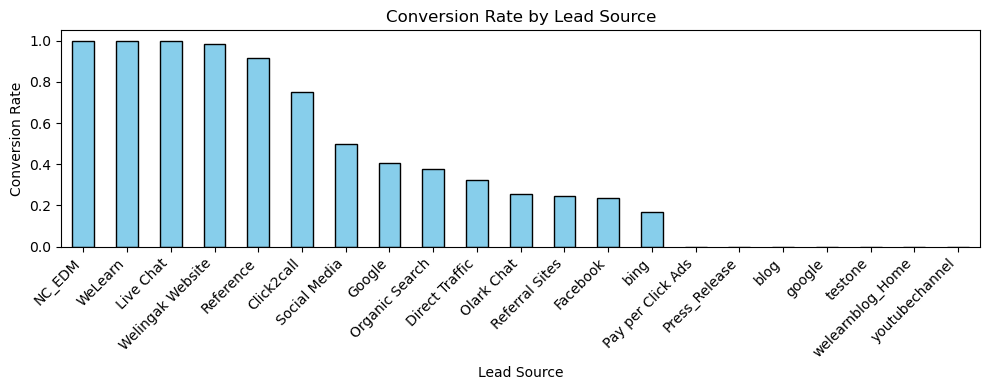

INSIGHT 2: High-converting sources should get priority in marketing budgets.


In [72]:
# Check in df instead of X
#  Conversion by Lead Source
if 'Lead Source' in df.columns:
    lead_source_conv = df.groupby('Lead Source')['Converted'].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(10, 4))
    lead_source_conv.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Conversion Rate by Lead Source')
    plt.ylabel('Conversion Rate')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("INSIGHT 2: High-converting sources should get priority in marketing budgets.")
else:
    print("'Lead Source' column not found in dataframe")

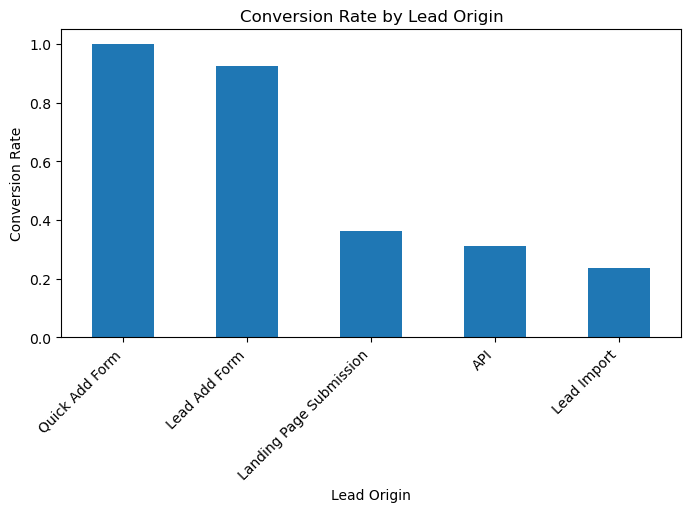

INSIGHT 3: Lead Origin is a strong segmentation variable — optimize acquisition channels accordingly.


In [73]:
# Insight 3: Conversion by Lead Origin
if 'Lead Origin' in df.columns:
    lead_origin_conv = df.groupby('Lead Origin')['Converted'].mean().sort_values(ascending=False)
    plt.figure(figsize=(8, 4))
    lead_origin_conv.plot(kind='bar')
    plt.title('Conversion Rate by Lead Origin')
    plt.ylabel('Conversion Rate')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    print("INSIGHT 3: Lead Origin is a strong segmentation variable — optimize acquisition channels accordingly.")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18396\429800780.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  visit_conv = df_visits.groupby('TotalVisits_bin')['Converted'].mean()


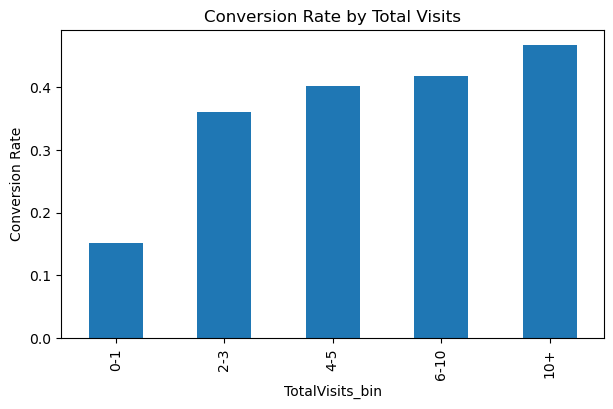

INSIGHT 4: Visitors with more site visits have higher conversion probability — retarget low-visit users.


In [74]:
# Insight 4: Total Visits vs Conversion
if 'TotalVisits' in df.columns:
    df_visits = df.copy()
    df_visits['TotalVisits_bin'] = pd.cut(df_visits['TotalVisits'], bins=[0, 1, 3, 5, 10, np.inf], labels=['0-1', '2-3', '4-5', '6-10', '10+'])
    visit_conv = df_visits.groupby('TotalVisits_bin')['Converted'].mean()
    plt.figure(figsize=(7, 4))
    visit_conv.plot(kind='bar')
    plt.title('Conversion Rate by Total Visits')
    plt.ylabel('Conversion Rate')
    plt.show()
    print("INSIGHT 4: Visitors with more site visits have higher conversion probability — retarget low-visit users.")


<Figure size 800x400 with 0 Axes>

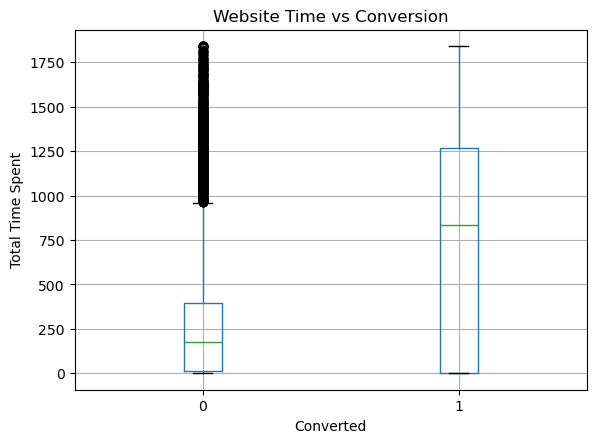

INSIGHT 5: Higher engagement time strongly correlates with conversion.


In [75]:
# Insight 5: Total Time Spent vs Conversion
if 'Total Time Spent on Website' in df.columns:
    plt.figure(figsize=(8, 4))
    df.boxplot(column='Total Time Spent on Website', by='Converted')
    plt.suptitle('')
    plt.title('Website Time vs Conversion')
    plt.ylabel('Total Time Spent')
    plt.show()
    print("INSIGHT 5: Higher engagement time strongly correlates with conversion.")


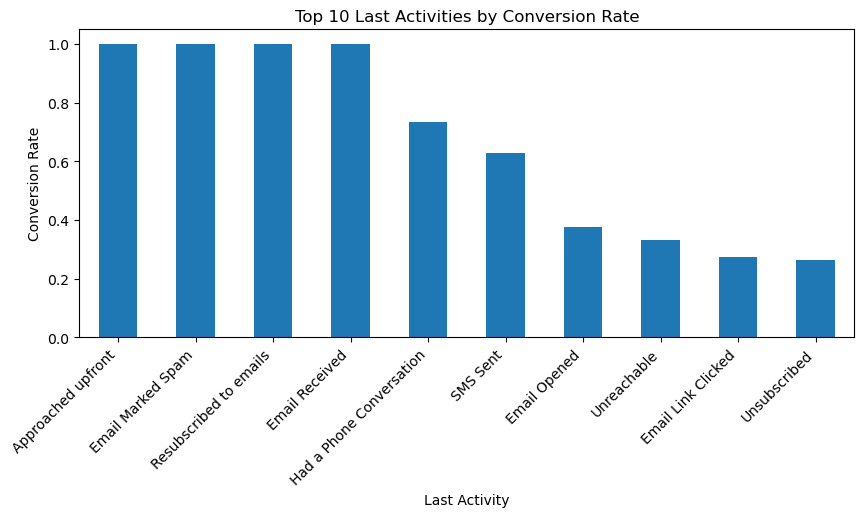

INSIGHT 6: Specific last activities (like Email Opened/Clicked) are strong triggers for follow-up.


In [76]:
# Insight 6: Last Activity Impact
if 'Last Activity' in df.columns:
    last_act_conv = df.groupby('Last Activity')['Converted'].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10, 4))
    last_act_conv.plot(kind='bar')
    plt.title('Top 10 Last Activities by Conversion Rate')
    plt.ylabel('Conversion Rate')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    print("INSIGHT 6: Specific last activities (like Email Opened/Clicked) are strong triggers for follow-up.")

In [77]:
# Insight 7: Feature Importance (RandomForest)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)
importances = rf.feature_importances_

In [78]:
# Get feature names from ColumnTransformer
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_names])
selected_features = feature_names[selector.get_support()]

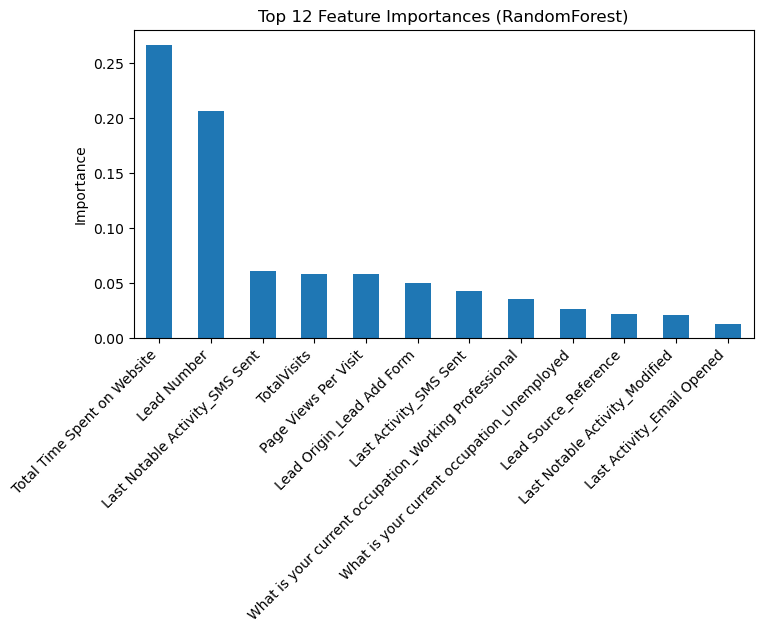

INSIGHT 7: Feature importance identifies key drivers for conversion — focus on these for data enrichment & targeting.


In [79]:
feat_imp = pd.Series(importances, index=selected_features).sort_values(ascending=False).head(12)
plt.figure(figsize=(8, 4))
feat_imp.plot(kind='bar')
plt.title('Top 12 Feature Importances (RandomForest)')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.show()
print("INSIGHT 7: Feature importance identifies key drivers for conversion — focus on these for data enrichment & targeting.")

In [80]:
# Precompute median safely
if 'Total Time Spent on Website' in df.columns:
    median_time_spent = df['Total Time Spent on Website'].median()

In [81]:
# Insight 8: Highly engaged leads
if 'TotalVisits' in df.columns and 'Total Time Spent on Website' in df.columns:
    engaged_leads = df.query("`TotalVisits` > 5 and `Total Time Spent on Website` > @median_time_spent")
    engaged_conv_rate = engaged_leads['Converted'].mean() * 100
    print(f"INSIGHT 8: Highly engaged leads (>5 visits & above-median time spent) convert at {engaged_conv_rate:.2f}% — prioritize them for sales follow-up.")


INSIGHT 8: Highly engaged leads (>5 visits & above-median time spent) convert at 55.65% — prioritize them for sales follow-up.


In [82]:
# Insight 9: Low-engagement leads
if 'TotalVisits' in df.columns and 'Total Time Spent on Website' in df.columns:
    low_engagement = df.query("`TotalVisits` <= 1 and `Total Time Spent on Website` <= @median_time_spent")
    low_conv_rate = low_engagement['Converted'].mean() * 100
    print(f"INSIGHT 9: Low-engagement leads (≤1 visit & low time spent) convert only {low_conv_rate:.2f}% — ideal candidates for automated nurturing.")


INSIGHT 9: Low-engagement leads (≤1 visit & low time spent) convert only 39.12% — ideal candidates for automated nurturing.


In [83]:
# Insight 10: Country segmentation
if 'Country' in df.columns:
    india_leads = df.query("Country == 'India'")
    india_conv = india_leads['Converted'].mean() * 100
    non_india_conv = df.query("Country != 'India'")['Converted'].mean() * 100
    print(f"INSIGHT 10: Conversion rate — India: {india_conv:.2f}%, Non-India: {non_india_conv:.2f}% — use geo-targeted marketing strategies.")


INSIGHT 10: Conversion rate — India: 38.84%, Non-India: 29.27% — use geo-targeted marketing strategies.


In [84]:
# Insight 11: Last Activity specific query
if 'Last Activity' in df.columns:
    email_opened = df.query("`Last Activity` == 'Email Opened'")
    email_opened_conv = email_opened['Converted'].mean() * 100
    print(f"INSIGHT 11: Leads with last activity 'Email Opened' convert at {email_opened_conv:.2f}% — prioritize them for direct outreach.")


INSIGHT 11: Leads with last activity 'Email Opened' convert at 37.68% — prioritize them for direct outreach.


In [85]:
# Insight 12: Leads opted out of emails
if 'Do Not Email' in df.columns:
    opt_out = df.query("`Do Not Email` == 'Yes'")
    opt_out_conv = opt_out['Converted'].mean() * 100
    print(f"INSIGHT 12: Do-Not-Email leads convert at {opt_out_conv:.2f}% — use SMS/Call campaigns instead.")


INSIGHT 12: Do-Not-Email leads convert at nan% — use SMS/Call campaigns instead.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18396\2000075272.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_conv = df.groupby('Engagement Segment')['Converted'].mean()


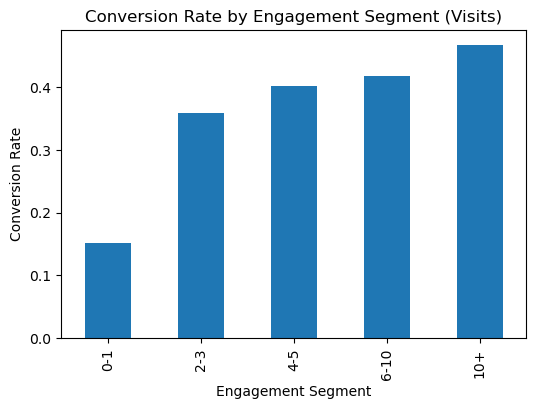

INSIGHT 13: Conversion rate increases with visit frequency — re-engagement campaigns should focus on 0-1 and 2-3 visit groups.


In [86]:
# 4. Visualization for Query Insights
# ==============================
if 'TotalVisits' in df.columns:
    plt.figure(figsize=(6, 4))
    df['Engagement Segment'] = pd.cut(df['TotalVisits'], bins=[0, 1, 3, 5, 10, np.inf],
                                      labels=['0-1', '2-3', '4-5', '6-10', '10+'])
    seg_conv = df.groupby('Engagement Segment')['Converted'].mean()
    seg_conv.plot(kind='bar')
    plt.title('Conversion Rate by Engagement Segment (Visits)')
    plt.ylabel('Conversion Rate')
    plt.show()
    print("INSIGHT 13: Conversion rate increases with visit frequency — re-engagement campaigns should focus on 0-1 and 2-3 visit groups.")

In [87]:
# Insight 15: Underperforming lead sources (filter and compare)
if 'Lead Source' in df.columns:
    low_sources = ['Olark Chat', 'Reference', 'Referral Sites']
    low_source_df = df[df['Lead Source'].isin(low_sources)]
    low_source_conv = low_source_df['Converted'].mean() * 100
    print(f"INSIGHT 15: Leads from {low_sources} convert at only {low_source_conv:.2f}% — review quality or reduce spend on these channels.")


INSIGHT 15: Leads from ['Olark Chat', 'Reference', 'Referral Sites'] convert at only 40.14% — review quality or reduce spend on these channels.


In [88]:
# Insight 16: Analyze leads by occupation
if 'What is your current occupation' in df.columns:
    focus_occupations = ['Working Professional', 'Student']
    occ_df = df[df['What is your current occupation'].isin(focus_occupations)]
    occ_conv = occ_df.groupby('What is your current occupation')['Converted'].mean() * 100
    print("INSIGHT 16: Conversion rates by focus occupations:")
    print(occ_conv)

INSIGHT 16: Conversion rates by focus occupations:
What is your current occupation
Student                 37.142857
Working Professional    91.643059
Name: Converted, dtype: float64


In [89]:
# Insight 17: Analyze leads from priority countries
if 'Country' in df.columns:
    priority_countries = ['India', 'USA', 'UAE']
    country_df = df[df['Country'].isin(priority_countries)]
    country_conv = country_df.groupby('Country')['Converted'].mean() * 100
    print("INSIGHT 17: Conversion rates by priority countries:")
    print(country_conv)

INSIGHT 17: Conversion rates by priority countries:
Country
India    38.836144
Name: Converted, dtype: float64


In [90]:
# Group by Lead Source and Occupation together
if 'Lead Source' in df.columns and 'What is your current occupation' in df.columns:
    combo_conv = df.groupby(['Lead Source', 'What is your current occupation'])['Converted'].mean() * 100
    print("\nConversion Rate by Lead Source & Occupation Combination:")
    print(combo_conv.sort_values(ascending=False).head(10))


Conversion Rate by Lead Source & Occupation Combination:
Lead Source     What is your current occupation
Organic Search  Housewife                          100.0
Facebook        Working Professional               100.0
Olark Chat      Other                              100.0
Reference       Businessman                        100.0
NC_EDM          Unemployed                         100.0
Live Chat       Unemployed                         100.0
Reference       Housewife                          100.0
                Other                              100.0
                Student                            100.0
Google          Housewife                          100.0
Name: Converted, dtype: float64


In [91]:
# Insight 18: Filter leads with last activity related to email engagement
if 'Last Activity' in df.columns:
    email_activities = ['Email Opened', 'Email Clicked', 'Email Bounced']
    email_df = df[df['Last Activity'].isin(email_activities)]
    email_conv = email_df.groupby('Last Activity')['Converted'].mean() * 100
    print("INSIGHT 18: Conversion rates by email-related last activities:")
    print(email_conv)

INSIGHT 18: Conversion rates by email-related last activities:
Last Activity
Email Bounced     7.975460
Email Opened     37.683616
Name: Converted, dtype: float64


In [92]:
# Top 5 Occupations by Conversion
if 'What is your current occupation' in df.columns:
    top_occ = df.groupby('What is your current occupation')['Converted'].mean().nlargest(5) * 100
    print("\nTop 5 Occupations by Conversion Rate:")
    print(top_occ)


Top 5 Occupations by Conversion Rate:
What is your current occupation
Housewife               100.000000
Working Professional     91.643059
Businessman              62.500000
Other                    62.500000
Student                  37.142857
Name: Converted, dtype: float64


In [93]:
# High vs Low Lead Sources
if 'Lead Source' in df.columns:
    high_sources = ['Google', 'Direct Traffic', 'Organic Search']
    low_sources = ['Olark Chat', 'Reference', 'Referral Sites']

    high_source_conv = df[df['Lead Source'].isin(high_sources)]['Converted'].mean() * 100
    low_source_conv = df[df['Lead Source'].isin(low_sources)]['Converted'].mean() * 100

    print(f"High Source Conversion: {high_source_conv:.2f}%")
    print(f"Low Source Conversion: {low_source_conv:.2f}%")



High Source Conversion: 36.81%
Low Source Conversion: 40.14%


In [94]:
# Pivot 2: Average Website Time by Lead Source
if 'Lead Source' in df.columns and 'Total Time Spent on Website' in df.columns:
    pivot_time = pd.pivot_table(df, 
                                values='Total Time Spent on Website', 
                                index='Lead Source', 
                                aggfunc=['mean','median'])
    print("\nPivot Table: Website Time by Lead Source (Mean & Median)")
    print(pivot_time.round(2))




Pivot Table: Website Time by Lead Source (Mean & Median)
                                         mean                      median
                  Total Time Spent on Website Total Time Spent on Website
Lead Source                                                              
Click2call                             509.00                       464.0
Direct Traffic                         604.46                       362.0
Facebook                               247.42                         0.0
Google                                 647.72                       431.0
Live Chat                                0.00                         0.0
NC_EDM                                 931.00                       931.0
Olark Chat                              61.28                         0.0
Organic Search                         625.67                       388.5
Pay per Click Ads                      125.00                       125.0
Press_Release                          805.00         

In [95]:
# Occupation-based Insight
if 'What is your current occupation' in df.columns:
    focus_occupations = ['Working Professional', 'Student']
    occ_conv = df[df['What is your current occupation'].isin(focus_occupations)] \
                .groupby('What is your current occupation')['Converted'].mean() * 100
    print("\nConversion Rate by Focus Occupations:")
    print(occ_conv)


Conversion Rate by Focus Occupations:
What is your current occupation
Student                 37.142857
Working Professional    91.643059
Name: Converted, dtype: float64


In [96]:
# Country-based Insight
if 'Country' in df.columns:
    priority_countries = ['India', 'USA', 'UAE']
    country_conv = df[df['Country'].isin(priority_countries)] \
                   .groupby('Country')['Converted'].mean() * 100
    print("\nConversion Rate by Priority Countries:")
    print(country_conv)


Conversion Rate by Priority Countries:
Country
India    38.836144
Name: Converted, dtype: float64


In [97]:
# Email-related Last Activity
if 'Last Activity' in df.columns:
    email_activities = ['Email Opened', 'Email Clicked', 'Email Bounced']
    email_conv = df[df['Last Activity'].isin(email_activities)] \
                 .groupby('Last Activity')['Converted'].mean() * 100
    print("\nConversion Rate by Email Activities:")
    print(email_conv)


Conversion Rate by Email Activities:
Last Activity
Email Bounced     7.975460
Email Opened     37.683616
Name: Converted, dtype: float64


In [98]:
# Group by Lead Source
if 'Lead Source' in df.columns:
    lead_source_conv = df.groupby('Lead Source')['Converted'].mean() * 100
    print("\nConversion Rate by Lead Source:")
    print(lead_source_conv.sort_values(ascending=False))


Conversion Rate by Lead Source:
Lead Source
NC_EDM               100.000000
WeLearn              100.000000
Live Chat            100.000000
Welingak Website      98.591549
Reference             91.760300
Click2call            75.000000
Social Media          50.000000
Google                40.495868
Organic Search        37.781629
Direct Traffic        32.166732
Olark Chat            25.527066
Referral Sites        24.800000
Facebook              23.636364
bing                  16.666667
Pay per Click Ads      0.000000
Press_Release          0.000000
blog                   0.000000
google                 0.000000
testone                0.000000
welearnblog_Home       0.000000
youtubechannel         0.000000
Name: Converted, dtype: float64


In [99]:
# Group by Last Activity
if 'Last Activity' in df.columns:
    activity_conv = df.groupby('Last Activity')['Converted'].mean() * 100
    print("\nConversion Rate by Last Activity:")
    print(activity_conv.sort_values(ascending=False).head(10))  # Top 10 activities



Conversion Rate by Last Activity:
Last Activity
Approached upfront          100.000000
Email Marked Spam           100.000000
Resubscribed to emails      100.000000
Email Received              100.000000
Had a Phone Conversation     73.333333
SMS Sent                     62.914390
Email Opened                 37.683616
Unreachable                  33.333333
Email Link Clicked           27.340824
Unsubscribed                 26.229508
Name: Converted, dtype: float64


In [100]:
# Crosstab 1: Lead Source vs Conversion Count
if 'Lead Source' in df.columns:
    ct_lead_source = pd.crosstab(df['Lead Source'], df['Converted'])
    print("\nCrosstab: Lead Source vs Conversion Count")
    print(ct_lead_source)


Crosstab: Lead Source vs Conversion Count
Converted             0     1
Lead Source                  
Click2call            1     3
Direct Traffic     1725   818
Facebook             42    13
Google             1728  1176
Live Chat             0     2
NC_EDM                0     1
Olark Chat         1307   448
Organic Search      718   436
Pay per Click Ads     1     0
Press_Release         2     0
Reference            44   490
Referral Sites       94    31
Social Media          1     1
WeLearn               0     1
Welingak Website      2   140
bing                  5     1
blog                  1     0
google                5     0
testone               1     0
welearnblog_Home      1     0
youtubechannel        1     0


In [101]:
# Group by Country
if 'Country' in df.columns:
    country_conv = df.groupby('Country')['Converted'].mean() * 100
    print("\nConversion Rate by Country:")
    print(country_conv.sort_values(ascending=False).head(10))  # Top 10 countries


Conversion Rate by Country:
Country
Denmark                100.000000
Bahrain                 57.142857
Hong Kong               57.142857
Asia/Pacific Region     50.000000
Oman                    50.000000
France                  50.000000
Netherlands             50.000000
Bangladesh              50.000000
Singapore               45.833333
India                   38.836144
Name: Converted, dtype: float64


In [102]:
# Crosstab 2: Occupation vs Conversion Rate (normalized)
if 'What is your current occupation' in df.columns:
    ct_occ = pd.crosstab(df['What is your current occupation'], df['Converted'], normalize='index')
    print("\nCrosstab: Occupation vs Conversion Rate (Normalized)")
    print((ct_occ * 100).round(2))  # Convert to %


Crosstab: Occupation vs Conversion Rate (Normalized)
Converted                            0       1
What is your current occupation               
Businessman                      37.50   62.50
Housewife                         0.00  100.00
Other                            37.50   62.50
Student                          62.86   37.14
Unemployed                       66.09   33.91
Working Professional              8.36   91.64


In [103]:
# Crosstab 3: Country vs Conversion Distribution (Top 5)
if 'Country' in df.columns:
    top_countries = df['Country'].value_counts().head(5).index
    ct_country = pd.crosstab(df[df['Country'].isin(top_countries)]['Country'], 
                             df['Converted'], normalize='index')
    print("\nCrosstab: Top 5 Countries vs Conversion Rate")
    print((ct_country * 100).round(2))


Crosstab: Top 5 Countries vs Conversion Rate
Converted                 0      1
Country                           
India                 61.16  38.84
Saudi Arabia          80.95  19.05
Singapore             54.17  45.83
United Arab Emirates  62.26  37.74
United States         73.91  26.09


In [104]:
# cut(): Bin TotalVisits into categories
if 'TotalVisits' in df.columns:
    df['Visit_Bins'] = pd.cut(df['TotalVisits'], 
                              bins=[0, 2, 5, 10, df['TotalVisits'].max()], 
                              labels=['Low', 'Medium', 'High', 'Very High'])
    visit_bin_conv = df.groupby('Visit_Bins')['Converted'].mean() * 100
    print("\nConversion Rate by Visit Bins (using cut):")
    print(visit_bin_conv)


Conversion Rate by Visit Bins (using cut):
Visit_Bins
Low          28.771084
Medium       40.346683
High         41.738449
Very High    46.742210
Name: Converted, dtype: float64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18396\1439457361.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  visit_bin_conv = df.groupby('Visit_Bins')['Converted'].mean() * 100


In [105]:
# qcut(): Bin Total Time Spent into quartiles
if 'Total Time Spent on Website' in df.columns:
    df['Time_Quartile'] = pd.qcut(df['Total Time Spent on Website'], 4, labels=['Q1','Q2','Q3','Q4'])
    time_quartile_conv = df.groupby('Time_Quartile')['Converted'].mean() * 100
    print("\nConversion Rate by Time Quartile (using qcut):")
    print(time_quartile_conv)


Conversion Rate by Time Quartile (using qcut):
Time_Quartile
Q1    40.172414
Q2    13.423110
Q3    30.909091
Q4    69.584055
Name: Converted, dtype: float64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18396\3603668270.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_quartile_conv = df.groupby('Time_Quartile')['Converted'].mean() * 100


In [106]:
# Correlation of numerical columns with Converted
numeric_cols = df.select_dtypes(include='number')
if 'Converted' in numeric_cols.columns:
    corr_matrix = numeric_cols.corr()
    conv_corr = corr_matrix['Converted'].sort_values(ascending=False)
    print("\nCorrelation of Features with Converted:")
    print(conv_corr)


Correlation of Features with Converted:
Converted                                   1.000000
Total Time Spent on Website                 0.363576
TotalVisits                                 0.043716
Lead Number                                 0.025171
Through Recommendations                     0.018607
Do Not Call                                 0.018581
Newspaper Article                           0.003465
Search                                     -0.002261
Page Views Per Visit                       -0.004603
Digital Advertisement                      -0.005789
Newspaper                                  -0.008238
X Education Forums                         -0.008238
A free copy of Mastering The Interview     -0.039820
Do Not Email                               -0.135580
Magazine                                         NaN
Receive More Updates About Our Courses           NaN
I agree to pay the amount through cheque         NaN
Name: Converted, dtype: float64


In [107]:
# Top 5 Lead Sources by Conversion Rate
if 'Lead Source' in df.columns:
    top_sources = df.groupby('Lead Source')['Converted'].mean().nlargest(5) * 100
    print("\nTop 5 Lead Sources by Conversion Rate:")
    print(top_sources)


Top 5 Lead Sources by Conversion Rate:
Lead Source
Live Chat           100.000000
NC_EDM              100.000000
WeLearn             100.000000
Welingak Website     98.591549
Reference            91.760300
Name: Converted, dtype: float64


In [108]:
# 1. Define X, y
# ==============================
# Assuming 'Converted' is the target column
X = df.drop(columns=['Converted'])
y = df['Converted']

In [109]:
# Convert categorical columns to dummy variables (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# ==============================

In [110]:
#  Train-Test Split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [55]:
#  Feature Scaling
# ==============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [56]:
# Base Logistic Regression Model
# ==============================
from sklearn.linear_model import LogisticRegression
base_model = LogisticRegression(max_iter=1000, random_state=42)
base_model.fit(X_train_scaled, y_train)
y_pred_base = base_model.predict(X_test_scaled)


In [57]:
print("=== Base Logistic Regression Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_base):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_base):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_base):.4f}")
print(f"f1 Score:  {f1_score(y_test, y_pred_base):.4f}")
print("\nClassification Report (Base Model):")
print(classification_report(y_test, y_pred_base))

=== Base Logistic Regression Performance ===
Accuracy:  0.7991
Precision: 0.8218
Recall:    0.6165
f1 Score:  0.7045

Classification Report (Base Model):
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1695
           1       0.82      0.62      0.70      1077

    accuracy                           0.80      2772
   macro avg       0.81      0.77      0.78      2772
weighted avg       0.80      0.80      0.79      2772



In [58]:
# 5. Hyperparameter Tuning with GridSearchCV
# ==============================
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [500, 1000]
}

In [59]:
grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

In [ ]:
grid.fit(X_train_scaled, y_train)

print("\n=== Best Parameters from GridSearchCV ===")
print(grid.best_params_)

In [ ]:
# 6. Tuned Model Performance
# ==============================
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)

print("\n=== Tuned Logistic Regression Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_best):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_best):.4f}")
print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_best))

In [ ]:
# 7. Before vs After Comparison
# ==============================
print("\n=== Performance Comparison ===")
print(f"Accuracy  | Base: {accuracy_score(y_test, y_pred_base):.4f}  ->  Tuned: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision | Base: {precision_score(y_test, y_pred_base):.4f}  ->  Tuned: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall    | Base: {recall_score(y_test, y_pred_base):.4f}  ->  Tuned: {recall_score(y_test, y_pred_best):.4f}")
print(f"F1 Score  | Base: {f1_score(y_test, y_pred_base):.4f}  ->  Tuned: {f1_score(y_test, y_pred_best):.4f}")

In [ ]:
# Confusion Matrix for Tuned Model
cm = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix (Tuned Model):")
print(cm)